# Image Classification using Keras and sklearn

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns # statistical data visualization, used to plot total count for each label
import random # used to split trainig and testing data
import warnings
import os # used to iterate through all the images in the specified directory

# libraries used for loading images and visualization
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn import utils

import PIL
from PIL import Image

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# image augmentation library 
import tensorflow_io as tfio

# import tensorflow
import tensorflow as tf


Spiral_DataSet1_relabelled\healthy\V01HE02.png 0
total number of labels:  102
total number of images:  102
                                                images  label
0    Spiral_DataSet1_relabelled\parkinsons\V10PE01.png      1
1       Spiral_DataSet1_relabelled\healthy\V04HE03.png      0
2       Spiral_DataSet1_relabelled\healthy\V08HE02.png      0
3       Spiral_DataSet1_relabelled\healthy\V55HE13.png      0
4    Spiral_DataSet1_relabelled\parkinsons\V06PE01.png      1
..                                                 ...    ...
97      Spiral_DataSet1_relabelled\healthy\V07HE02.png      0
98   Spiral_DataSet1_relabelled\parkinsons\V03PE02.png      1
99   Spiral_DataSet1_relabelled\parkinsons\V03PE05.png      1
100  Spiral_DataSet1_relabelled\parkinsons\V09PE03.png      1
101     Spiral_DataSet1_relabelled\healthy\V11HE03.png      0

[102 rows x 2 columns]


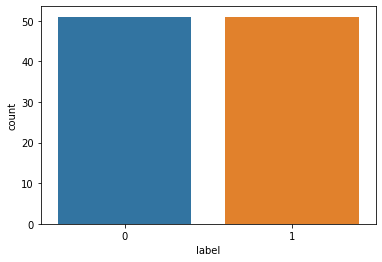

In [18]:
## --------------------------------------------------------
#                  Create the Dataframe
## --------------------------------------------------------
img_path = [] # store image paths for all images (all images are size 256x256)
label = [] # healthy (0) vs parkinsons (1)
dataset_folder = 'Spiral_DataSet1_relabelled'

# iterate through all of the images to create a binary array corresponding to the image labels
for labeled_folder in os.listdir(dataset_folder):
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        if labeled_folder == 'healthy':
            label.append(0)
        else:
            label.append(1)
        img_path.append(os.path.join(dataset_folder, labeled_folder, img))

# total number of images and labels should match
print(img_path[1], label[1])
print("total number of labels: ", len(label))
print("total number of images: ", len(img_path))

# now create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label']  = label


df = df.sample(frac=1).reset_index(drop=True) # randomize the images, rather than having them be in order

print(df)

# show the total count for each of the labels
sns.countplot(df['label'])
plt.show()

In [19]:
## -----------------------------------------------------------
#               Split into test and training data
## -----------------------------------------------------------
#randomly split data in train and test subsets
x_feature, val_feature, x_label, val_label = train_test_split(df['images'], df['label'], test_size=0.2, shuffle=False)

# train, test = train_test_split(df, test_size=0.2, shuffle=False)



# shuffle data
x_feature, x_label = utils.shuffle(x_feature, x_label)
val_feature, val_label = utils.shuffle(val_feature, val_label)

print("pause")
# convert y-col to str for binary class_mode
# train['label'] = train['label'].astype('str')
# test['label']  = test['label'].astype('str')

pause


In [20]:
## ------------------------------------------
#       Convert images to raw pixels
## ------------------------------------------
train_array = []
val_array = []

for img_path in x_feature:
    openImg = PIL.Image.open(img_path)
    image = openImg.convert("P") # covert to grayscale
    imgArray = np.array(image)
    imgArray = np.expand_dims(imgArray, axis=2)

    # store in array
    train_array.append(imgArray)

for img_path in val_feature:
    openImg = PIL.Image.open(img_path)
    image = openImg.convert("L") # covert to grayscale
    imgArray = np.array(image)
    imgArray = np.expand_dims(imgArray, axis=2)

    # store in array
    val_array.append(imgArray)


print("pause")


pause


In [21]:
## -------------------------------------------------------------------
#       Artificially create more images for a bigger dataset
## -------------------------------------------------------------------
# normalize the data
train_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

## add more training images
trainAug = []
trainAugLabel = []

for (i,v) in enumerate(x_label):
    #print("i: ", i)
    #print("v: ", v)
    tempImg = np.expand_dims(train_array[i], axis=0)
    aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
    for addImages in range(50):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 256**2:
            trainAug.append(augImg)
            trainAugLabel.append(v)

## add more validation images
testAug = []
testAugLabel = []

for (i,v) in enumerate(val_label):
    #print("i: ", i)
    #print("v: ", v)
    tempImg = np.expand_dims(val_array[i], axis=0)
    aug = test_gen.flow(tempImg, batch_size=1)
    for addImages in range(50):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 256**2:
            testAug.append(augImg)
            testAugLabel.append(v)

print("pause")

# convert everything to numpy arrays (CNN does not like lists)
# trainAug = np.array(trainAug)
# testAug = np.array(testAug)

#trainAug = train_array + trainAug
#testAug = val_array + testAug

trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
testAugLabel = tf.keras.utils.to_categorical(np.array(testAugLabel))


print("pause")

# shuffle data
trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
testAug, testAugLabel = utils.shuffle(testAug, testAugLabel)



pause
pause


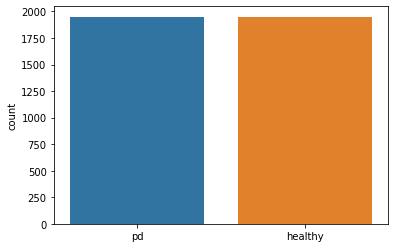

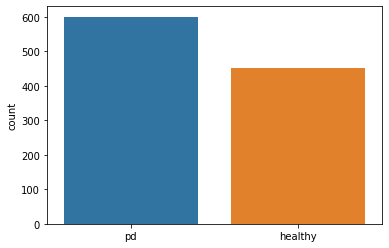

0.27


In [12]:
sns.countplot(trainAugLabel)
plt.show()
sns.countplot(testAugLabel)
plt.show()

print(np.round(len(testAug)/len(trainAug),2))

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        #newImg=tf.image.rgb_to_hsv(img)
        ax.imshow(img, cmap="gray")       # applies a colormap by default      
        
    plt.tight_layout()
    plt.show()

In [ ]:
augmented_images = [testAug[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [15]:
# plot images
imfile = Image.fromarray(np.squeeze(testAug[2]))
imfile.show(imfile)     

In [ ]:
## -----------------------------------------------------------
#                       Build the Model
## -----------------------------------------------------------

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1,activation='sigmoid')
])

'''
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])
'''

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, epochs=50, validation_data=(np.array(testAug), testAugLabel))

In [22]:
reg = tf.keras.regularizers.l2(0.001)
opt = tf.keras.optimizers.Adam(learning_rate=3.15e-5)

model = Sequential([
    Conv2D(128, (5,5), padding='same', strides=(1,1), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=reg, input_shape=(256,256,1)),
    MaxPool2D((9,9), strides=(3,3)),
    Conv2D(64, (5,5), padding='same', strides=(1,1), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=reg),
    MaxPool2D((7,7), strides=(3,3)),
    Conv2D(32, (3,3), padding='same', strides=(1,1), activation='relu',kernel_initializer ='glorot_uniform', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(32, (3,3), padding='same', strides=(1,1), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_initializer='glorot_uniform'),
    Dropout(0.5),
    Dense(2,activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, epochs=50, validation_data=(np.array(testAug), testAugLabel))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 128)     3328      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 83, 83, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 83, 83, 64)        204864    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 32)      

In [ ]:
## -----------------------------------------------------------
#                       Plot the Results
## -----------------------------------------------------------
# Accuracy and Validation Accuracy
accuracy = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.grid()
plt.figure()

# Loss and Validation Loss
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.grid()
plt.show()

## Model #2 